# MusicXML Tokenizer v2 — Structural Completeness

**Goal:** Capture all remaining musical features — repeats, endings, fermatas, tempo, dynamics, lyrics, barlines — for a structurally complete tokenization of SymbTr v3 Turkish makam MusicXML files.

**v2 improvements over v1:**
- Repeats: `REPEAT_FWD`, `REPEAT_BWD` (from `<barline><repeat>`)
- Endings: `ENDING_<n>_START`, `ENDING_<n>_STOP` (from `<barline><ending>`)
- Barlines: `BARLINE_<style>` (from `<barline><bar-style>`)
- Fermata: `FERMATA` (from `<notations><fermata>`)
- Tempo: `TEMPO_<bpm>` (from `<direction><sound tempo>` and `<metronome>`)
- Dynamics: `DYNAMICS_<type>` (from `<direction><dynamics>`)
- Lyrics: `LYRIC_<syllable>` (from `<lyric>`, inline after note)

**All token types:** `<BOS>`, `<EOS>`, `PART_`, `TIME_SIG_`, `KEY_`, `CLEF_`, `BAR_`, `POS_BAR_`, `POS_ABS_`, `PITCH_`, `DUR_`, `REST`, `TIE_START`, `TIE_STOP`, `GRACE_`, `REPEAT_FWD`, `REPEAT_BWD`, `ENDING_`, `BARLINE_`, `FERMATA`, `TEMPO_`, `DYNAMICS_`, `LYRIC_`

---

## 1. Setup and Dependencies

In [11]:
# ── Install dependencies (for Google Colab) ──
# Uncomment the following lines if running on Colab:
# !pip install lxml music21 python-Levenshtein pandas matplotlib

import os
import glob
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from fractions import Fraction

from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

# Suppress music21 warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# We import music21 for the detokenizer and evaluation only
import music21

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

print(f"lxml version: {etree.LXML_VERSION}")
print(f"music21 version: {music21.VERSION_STR}")
print("Setup complete.")

lxml version: (6, 0, 2, 0)
music21 version: 9.9.1
Setup complete.


## 2. Load Dataset File Paths

In [12]:
# ── Load all XML file paths from xml_v3/ ──
XML_DIR = Path("xml_v3")

# Also support Colab path structure
if not XML_DIR.exists():
    # Try relative to notebook location
    XML_DIR = Path("/content/musicxml_tokenizer/xml_v3")

all_xml_files = sorted(XML_DIR.glob("*.xml"))
print(f"Total XML files found: {len(all_xml_files)}")
print(f"\nFirst 5 files:")
for f in all_xml_files[:5]:
    print(f"  {f.name}")
print(f"\nLast 5 files:")
for f in all_xml_files[-5:]:
    print(f"  {f.name}")

# Select a random 100-file sample for evaluation
EVAL_SAMPLE_SIZE = 100
eval_sample = random.sample(all_xml_files, min(EVAL_SAMPLE_SIZE, len(all_xml_files)))
print(f"\nEvaluation sample size: {len(eval_sample)}")

Total XML files found: 3000

First 5 files:
  acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml
  acem--ilahi--nimevsat--calabim_bir--haci_bayram_veli.xml
  acem--kupe--duyek--zulfunu--ahmet_avni_konuk.xml
  acem--selam--devrikebir--asik-i_ger--huseyin_fahreddin_dede.xml
  acem--seyir--sofyan----sefik_gurmeric.xml

Last 5 files:
  zavil--turku--sofyan--uc_gun--.xml
  zevk-itarab--kupe--musemmen--meclis-i--ahmet_avni_konuk.xml
  zevkidil--kupe--devrirevan--gel--ahmet_avni_konuk.xml
  zirefkend--kupe--aksaksemai--pertev-i--ahmet_avni_konuk.xml
  zirefkend--pesrev--darbifetih----gazi_giray_han.xml

Evaluation sample size: 100


## 2b. Build Microtonal Pitch Map from Full Corpus

Scan all 3,000 files to extract every unique `(step, alter)` pair, convert to a cent-grid at 0.01 resolution, and build a bidirectional mapping for lossless pitch tokenization.

In [13]:
# ── Scan corpus for all unique (step, alter) pairs ──
# This builds the microtonal pitch mapping used by the tokenizer.

from collections import defaultdict
import json

print("Scanning full corpus for microtonal pitch data...")
step_alter_pairs = set()
alter_values_by_step = defaultdict(set)
parse_errors = 0

for i, fp in enumerate(all_xml_files):
    if (i + 1) % 500 == 0:
        print(f"  Scanned {i + 1}/{len(all_xml_files)} files...")
    try:
        tree = etree.parse(str(fp))
        root = tree.getroot()
        for pitch_elem in root.iter("pitch"):
            step = pitch_elem.findtext("step", "C")
            alter_text = pitch_elem.findtext("alter")
            alter = float(alter_text) if alter_text else 0.0
            step_alter_pairs.add((step, alter))
            alter_values_by_step[step].add(alter)
    except Exception:
        parse_errors += 1

print(f"\nScan complete!")
print(f"  Parse errors: {parse_errors}")
print(f"  Unique (step, alter) pairs: {len(step_alter_pairs)}")
print(f"\nPer-step breakdown:")
for step in sorted(alter_values_by_step.keys()):
    alters = sorted(alter_values_by_step[step])
    print(f"  {step}: {len(alters)} alter values")
    # Show the alter values
    for a in alters:
        cents = round(a * 100, 2)
        print(f"      alter={a:+.8f}  →  {cents:+.2f} cents")

# ── Build cent-grid pitch map ──
# Convert each (step, alter) → a cent offset from the natural note
# Round to 0.01 cent resolution for the grid
# Token format: PITCH_<step>_<centOffset>_<octave>
#   e.g., PITCH_C_0.00_5  (natural C5)
#         PITCH_F_-7.55_5  (F5 lowered by 7.55 cents)

# Build forward map: (step, alter) → cent_label
# Build reverse map: cent_label → (step, alter)  for detokenization

pitch_map = {}        # (step, alter_rounded) → cent_label string
pitch_reverse = {}    # cent_label string → (step, alter_float)

for step, alter in sorted(step_alter_pairs):
    cents = round(alter * 100, 2)  # 0.01 cent resolution
    cent_label = f"{cents:+.2f}"   # e.g., "+0.00", "-7.55", "-92.45"
    key = (step, round(alter, 8))
    pitch_map[key] = f"{step}_{cent_label}"
    pitch_reverse[f"{step}_{cent_label}"] = (step, alter)

print(f"\nPitch map built: {len(pitch_map)} entries")
print(f"Reverse map built: {len(pitch_reverse)} entries")

# Show a few examples
print(f"\nExample mappings:")
for (step, alter), label in list(sorted(pitch_map.items()))[:10]:
    print(f"  ({step}, {alter:+.8f}) → {label}")

Scanning full corpus for microtonal pitch data...
  Scanned 500/3000 files...
  Scanned 1000/3000 files...
  Scanned 1500/3000 files...
  Scanned 2000/3000 files...
  Scanned 2500/3000 files...
  Scanned 3000/3000 files...

Scan complete!
  Parse errors: 70
  Unique (step, alter) pairs: 119

Per-step breakdown:
  A: 20 alter values
      alter=-1.35849056  →  -135.85 cents
      alter=-1.13207547  →  -113.21 cents
      alter=-1.07547170  →  -107.55 cents
      alter=-0.90566037  →  -90.57 cents
      alter=-0.84905660  →  -84.91 cents
      alter=-0.67924528  →  -67.92 cents
      alter=-0.62264151  →  -62.26 cents
      alter=-0.45283019  →  -45.28 cents
      alter=-0.39622642  →  -39.62 cents
      alter=-0.22641509  →  -22.64 cents
      alter=+0.00000000  →  +0.00 cents
      alter=+0.05660377  →  +5.66 cents
      alter=+0.22641510  →  +22.64 cents
      alter=+0.28301887  →  +28.30 cents
      alter=+0.45283019  →  +45.28 cents
      alter=+0.67924529  →  +67.92 cents
      alt

## 2c. Corpus Feature Scan (v2)

Scan all files for structural features new to v2: repeats, endings, fermatas, tempo markings, dynamics, lyrics, and barline styles.

In [21]:
# ── Corpus-wide scan for v2 structural features ──
print("Scanning corpus for v2 structural features...\n")

feature_counts = Counter()  # feature_name → number of files containing it
feature_values = defaultdict(Counter)  # feature_name → {value → count}
scan_errors = 0

for i, fp in enumerate(all_xml_files):
    if (i + 1) % 500 == 0:
        print(f"  Scanned {i + 1}/{len(all_xml_files)} files...")
    try:
        tree = etree.parse(str(fp))
        root = tree.getroot()

        # Repeats: <barline><repeat direction="forward|backward"/>
        repeats = root.findall(".//barline/repeat")
        if repeats:
            feature_counts['repeat'] += 1
            for r in repeats:
                direction = r.get("direction", "?")
                feature_values['repeat_direction'][direction] += 1

        # Endings: <barline><ending number="N" type="start|stop|discontinue">
        endings = root.findall(".//barline/ending")
        if endings:
            feature_counts['ending'] += 1
            for e in endings:
                etype = e.get("type", "?")
                enum = e.get("number", "?")
                feature_values['ending_type'][etype] += 1
                feature_values['ending_number'][enum] += 1

        # Barline styles: <barline><bar-style>
        barlines = root.findall(".//barline/bar-style")
        if barlines:
            feature_counts['barline_style'] += 1
            for b in barlines:
                if b.text:
                    feature_values['bar_style'][b.text] += 1

        # Fermata: <notations><fermata>
        fermatas = root.findall(".//notations/fermata")
        if fermatas:
            feature_counts['fermata'] += 1
            feature_values['fermata_count']['total'] += len(fermatas)

        # Tempo / Sound: <sound tempo="..."> or <direction><sound tempo="...">
        sounds = root.findall(".//sound[@tempo]")
        if sounds:
            feature_counts['tempo'] += 1
            for s in sounds:
                tempo = s.get("tempo", "?")
                feature_values['tempo_bpm'][tempo] += 1

        # Metronome: <direction><direction-type><metronome>
        metronomes = root.findall(".//metronome")
        if metronomes:
            feature_counts['metronome'] += 1

        # Dynamics: <direction><direction-type><dynamics>
        dynamics = root.findall(".//dynamics")
        if dynamics:
            feature_counts['dynamics'] += 1
            for d in dynamics:
                for child in d:
                    feature_values['dynamics_type'][child.tag] += 1

        # Lyrics: <note><lyric>
        lyrics = root.findall(".//lyric")
        if lyrics:
            feature_counts['lyrics'] += 1
            feature_values['lyrics_count']['total'] += len(lyrics)

        # Articulations: <notations><articulations>
        articulations = root.findall(".//notations/articulations")
        if articulations:
            feature_counts['articulations'] += 1
            for art in articulations:
                for child in art:
                    feature_values['articulation_type'][child.tag] += 1

        # Slurs: <notations><slur>
        slurs = root.findall(".//notations/slur")
        if slurs:
            feature_counts['slur'] += 1

    except Exception:
        scan_errors += 1

total_files = len(all_xml_files) - scan_errors
print(f"\nScan complete! ({scan_errors} parse errors)\n")
print(f"{'Feature':<20} {'Files':>8} {'% of corpus':>12}")
print(f"{'─' * 20} {'─' * 8} {'─' * 12}")
for feat in sorted(feature_counts.keys()):
    count = feature_counts[feat]
    pct = count / total_files * 100
    print(f"{feat:<20} {count:>8} {pct:>11.1f}%")

print(f"\n\nDetailed value distributions:")
for feat_name in sorted(feature_values.keys()):
    vals = feature_values[feat_name]
    print(f"\n  {feat_name}:")
    for val, cnt in vals.most_common(20):
        print(f"    {val}: {cnt}")

Scanning corpus for v2 structural features...

  Scanned 500/3000 files...
  Scanned 1000/3000 files...
  Scanned 1500/3000 files...
  Scanned 2000/3000 files...
  Scanned 2500/3000 files...
  Scanned 3000/3000 files...

Scan complete! (70 parse errors)

Feature                 Files  % of corpus
──────────────────── ──────── ────────────
articulations             492        16.8%
barline_style            1933        66.0%
dynamics                  272         9.3%
ending                   1325        45.2%
fermata                   189         6.5%
lyrics                   2483        84.7%
metronome                2930       100.0%
repeat                   1933        66.0%
slur                     2320        79.2%
tempo                    2930       100.0%


Detailed value distributions:

  articulation_type:
    staccato: 3816

  bar_style:
    heavy-light: 4918
    light-heavy: 4878

  dynamics_type:
    p: 2645
    f: 1176
    pp: 97

  ending_number:
    1: 5463
    2: 5459
   

## 3. Parse MusicXML Structure with lxml

Explore the XML tree structure of a sample file to confirm the parsing approach.

In [3]:
# ── Explore MusicXML structure of a sample file ──
sample_file = all_xml_files[0]
print(f"Exploring: {sample_file.name}\n")

tree = etree.parse(str(sample_file))
root = tree.getroot()

# Show top-level structure
print("Root tag:", root.tag)
print("Top-level children:")
for child in root:
    print(f"  <{child.tag}>")

# Show part-list → part names
part_list = root.find("part-list")
if part_list is not None:
    for sp in part_list.findall("score-part"):
        pid = sp.get("id")
        pname = sp.findtext("part-name", default="?")
        print(f"\n  Part ID={pid}, Name='{pname}'")

# Show first measure structure
parts = root.findall("part")
print(f"\nNumber of parts: {len(parts)}")
first_part = parts[0]
first_measure = first_part.find("measure")
print(f"\nFirst measure (number={first_measure.get('number')}) children:")
for child in first_measure:
    print(f"  <{child.tag}>", {k: v for k, v in child.attrib.items()} if child.attrib else "")
    for sub in child:
        txt = sub.text.strip() if sub.text and sub.text.strip() else ""
        print(f"    <{sub.tag}> {txt}")

# Show divisions
attrs = first_measure.find("attributes")
if attrs is not None:
    div = attrs.findtext("divisions")
    print(f"\nDivisions per quarter note: {div}")

Exploring: acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml

Root tag: score-partwise
Top-level children:
  <work>
  <identification>
  <defaults>
  <credit>
  <credit>
  <credit>
  <credit>
  <credit>
  <part-list>
  <part>

  Part ID=P1, Name='S'

Number of parts: 1

First measure (number=1) children:
  <attributes> 
    <divisions> 192
    <time> 
  <attributes> 
    <key> 
  <direction> {'placement': 'above'}
    <direction-type> 
    <sound> 
  <direction> {'placement': 'above'}
    <direction-type> 
    <sound> 
  <direction> {'placement': 'above'}
    <direction-type> 
  <note> 
    <pitch> 
    <duration> 192
    <type> quarter
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
    <duration> 144
    <type> eighth
    <dot> 
    <notations> 
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
    <duration> 48
    <type> 16th
    <notations> 
  <note> 
    <pitch> 
    <duration> 48
    <type> 16th
    <beam> begin
    <notations> 
    <lyric> 
    <lyric> 
  <note> 
    <pitch> 
 

## 4. Helper Functions for Pitch, Duration, Key, and Time Signature Extraction

In [ ]:
# ── Helper functions for tokenization (v2) ──

def get_part_name(root, part_id):
    """Look up part name from <part-list> given a part ID."""
    part_list = root.find("part-list")
    if part_list is not None:
        for sp in part_list.findall("score-part"):
            if sp.get("id") == part_id:
                name = sp.findtext("part-name", default="")
                if not name or name.strip() == "":
                    instr = sp.find(".//instrument-name")
                    if instr is not None and instr.text:
                        name = instr.text
                return name.strip() if name else "Unknown"
    return "Unknown"


def extract_pitch(note_elem):
    """Extract pitch from a <note> element using microtonal cent-grid.
    Returns 'PITCH_<step>_<cents>_<octave>' string."""
    pitch_elem = note_elem.find("pitch")
    if pitch_elem is None:
        return None
    step = pitch_elem.findtext("step", default="C")
    octave = pitch_elem.findtext("octave", default="4")
    alter_text = pitch_elem.findtext("alter")
    alter = float(alter_text) if alter_text else 0.0

    key = (step, round(alter, 8))
    if key in pitch_map:
        cent_label = pitch_map[key]
        return f"PITCH_{cent_label}_{octave}"
    else:
        cents = round(alter * 100, 2)
        cent_label = f"{cents:+.2f}"
        return f"PITCH_{step}_{cent_label}_{octave}"


def extract_duration_ql(note_elem, divisions):
    """Convert <duration> to quarter-note length using divisions."""
    dur_text = note_elem.findtext("duration")
    if dur_text is None:
        return 0.0
    duration = int(dur_text)
    if divisions == 0:
        return 0.0
    ql = duration / divisions
    return round(ql, 6)


def is_rest(note_elem):
    """Check if a <note> element is a rest."""
    return note_elem.find("rest") is not None


def is_grace_note(note_elem):
    """Check if a <note> element is a grace note (no duration contribution)."""
    return note_elem.find("grace") is not None


def has_tie(note_elem):
    """Check for tie start/stop on a note. Returns list of tie types."""
    ties = []
    for tie_elem in note_elem.findall("tie"):
        tie_type = tie_elem.get("type")
        if tie_type:
            ties.append(tie_type)
    return ties


def has_fermata(note_elem):
    """Check if a note has a fermata. Returns True if fermata found."""
    notations = note_elem.find("notations")
    if notations is not None:
        return notations.find("fermata") is not None
    return False


def extract_lyrics(note_elem):
    """Extract lyric syllables from a <note> element.
    Returns list of lyric text strings."""
    lyrics = []
    for lyric_elem in note_elem.findall("lyric"):
        text_elem = lyric_elem.find("text")
        if text_elem is not None and text_elem.text:
            syllabic = lyric_elem.findtext("syllabic", default="single")
            text = text_elem.text.strip()
            if text:
                lyrics.append(text)
    return lyrics


def extract_barline_tokens(measure_elem):
    """Extract barline-related tokens (repeats, endings, bar-styles) from a measure.
    Returns (pre_tokens, post_tokens) — tokens to emit before and after the bar's notes.
    Pre-tokens: forward repeats, ending starts.
    Post-tokens: backward repeats, ending stops, special barline styles."""
    pre_tokens = []
    post_tokens = []

    for barline_elem in measure_elem.findall("barline"):
        location = barline_elem.get("location", "right")

        # Repeat
        repeat_elem = barline_elem.find("repeat")
        if repeat_elem is not None:
            direction = repeat_elem.get("direction", "")
            if direction == "forward":
                pre_tokens.append("REPEAT_FWD")
            elif direction == "backward":
                post_tokens.append("REPEAT_BWD")

        # Ending
        ending_elem = barline_elem.find("ending")
        if ending_elem is not None:
            ending_num = ending_elem.get("number", "1")
            ending_type = ending_elem.get("type", "")
            if ending_type == "start":
                pre_tokens.append(f"ENDING_{ending_num}_START")
            elif ending_type in ("stop", "discontinue"):
                post_tokens.append(f"ENDING_{ending_num}_STOP")

        # Bar style (only non-standard styles)
        style_elem = barline_elem.find("bar-style")
        if style_elem is not None and style_elem.text:
            style = style_elem.text
            if style not in ("regular",):  # Skip default style
                if location == "left":
                    pre_tokens.append(f"BARLINE_{style}")
                else:
                    post_tokens.append(f"BARLINE_{style}")

    return pre_tokens, post_tokens


def extract_direction_tokens(direction_elem):
    """Extract tokens from a <direction> element (tempo, dynamics).
    Returns list of token strings."""
    tokens = []

    # Sound element with tempo
    sound_elem = direction_elem.find("sound")
    if sound_elem is not None:
        tempo = sound_elem.get("tempo")
        if tempo:
            try:
                bpm = int(float(tempo))
                if bpm > 0:
                    tokens.append(f"TEMPO_{bpm}")
            except ValueError:
                pass

    # Direction-type children
    for dtype in direction_elem.findall("direction-type"):
        # Dynamics
        dynamics_elem = dtype.find("dynamics")
        if dynamics_elem is not None:
            for child in dynamics_elem:
                tokens.append(f"DYNAMICS_{child.tag}")

    return tokens


def extract_key_signature(key_elem):
    """Parse a <key> element and return a KEY_ token string."""
    if key_elem is None:
        return None

    fifths = key_elem.findtext("fifths")
    if fifths is not None:
        fifths_int = int(fifths)
        mode = key_elem.findtext("mode", default="major")
        major_keys = ["C", "G", "D", "A", "E", "B", "F#",
                       "Gb", "Db", "Ab", "Eb", "Bb", "F"]
        minor_keys = ["A", "E", "B", "F#", "C#", "G#", "D#",
                       "Eb", "Bb", "F", "C", "G", "D"]
        if mode == "minor":
            tonic = minor_keys[fifths_int] if -6 <= fifths_int <= 6 else "A"
        else:
            tonic = major_keys[fifths_int] if -6 <= fifths_int <= 6 else "C"
        return f"KEY_{tonic}_{mode}"

    key_steps = key_elem.findall("key-step")
    key_alters = key_elem.findall("key-alter")
    key_accidentals = key_elem.findall("key-accidental")

    if key_steps:
        parts = []
        for i, step_elem in enumerate(key_steps):
            step = step_elem.text
            alter = key_alters[i].text if i < len(key_alters) else "0"
            accidental = key_accidentals[i].text if i < len(key_accidentals) else ""
            if accidental:
                parts.append(f"{step}-{accidental}")
            else:
                parts.append(f"{step}({alter})")
        return "KEY_" + "_".join(parts)

    return None


def extract_time_signature(time_elem):
    """Parse a <time> element and return 'TIME_SIG_<beats>/<beat-type>'."""
    if time_elem is None:
        return None
    beats = time_elem.findtext("beats", default="4")
    beat_type = time_elem.findtext("beat-type", default="4")
    return f"TIME_SIG_{beats}/{beat_type}"


def format_position(pos):
    """Format a position value to a clean string."""
    if pos == int(pos):
        return str(int(pos)) + ".0"
    else:
        result = f"{pos:.4f}".rstrip('0')
        if result.endswith('.'):
            result += '0'
        return result


# Quick test of helpers
print("Helper functions (v2) defined successfully.")
print(f"format_position(0) = '{format_position(0)}'")

sample_tree = etree.parse(str(all_xml_files[0]))
sample_root = sample_tree.getroot()
sample_note = sample_root.find(".//note[pitch]")
if sample_note is not None:
    p = extract_pitch(sample_note)
    print(f"Sample pitch token: {p}")
    print(f"Ties: {has_tie(sample_note)}")
    print(f"Fermata: {has_fermata(sample_note)}")
    print(f"Lyrics: {extract_lyrics(sample_note)}")

# Test barline extraction
for measure in sample_root.findall(".//measure"):
    pre, post = extract_barline_tokens(measure)
    if pre or post:
        print(f"\nMeasure {measure.get('number')}: pre={pre}, post={post}")
        break

# Test direction extraction
for direction in sample_root.findall(".//direction"):
    dtokens = extract_direction_tokens(direction)
    if dtokens:
        print(f"Direction tokens: {dtokens}")
        break

Helper functions (v1) defined successfully.
format_position(0) = '0.0'
format_position(1.5) = '1.5'
format_position(0.25) = '0.25'

Sample pitch token: PITCH_C_-5.66_5
Sample note ties: []


## 5. Implement `tokenize(xml_path) → list[str]`

The main tokenizer function. Parses MusicXML with `lxml`, walks the tree, and emits a flat list of string tokens.

**Partwise tokenization:** Each part's bars are emitted contiguously under a `PART_` header before moving to the next part.

In [ ]:
def tokenize(xml_path):
    """Tokenize a MusicXML file into a list of string tokens.

    v2 additions over v1:
      - REPEAT_FWD / REPEAT_BWD tokens
      - ENDING_<n>_START / ENDING_<n>_STOP tokens
      - BARLINE_<style> tokens (non-regular barlines)
      - FERMATA token (on notes with fermata notation)
      - TEMPO_<bpm> tokens (from <direction><sound tempo>)
      - DYNAMICS_<type> tokens (from <direction><dynamics>)
      - LYRIC_<syllable> tokens (inline after note)

    Args:
        xml_path: Path to a MusicXML (.xml) file.

    Returns:
        List of string tokens representing the score.
    """
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    tokens = ["<BOS>"]

    for part_elem in root.findall("part"):
        part_id = part_elem.get("id")
        part_name = get_part_name(root, part_id)
        tokens.append(f"PART_{part_name}")

        current_time_sig = None
        current_key = None
        clef_emitted = False
        divisions = 1
        pos_abs = 0.0

        for measure in part_elem.findall("measure"):
            measure_number = measure.get("number", "0")

            # ── Process <attributes> for key, time, clef, divisions ──
            for attrs in measure.findall("attributes"):
                div_text = attrs.findtext("divisions")
                if div_text is not None:
                    divisions = int(div_text)

                time_elem = attrs.find("time")
                if time_elem is not None:
                    new_time_sig = extract_time_signature(time_elem)
                    if new_time_sig and new_time_sig != current_time_sig:
                        tokens.append(new_time_sig)
                        current_time_sig = new_time_sig

                key_elem = attrs.find("key")
                if key_elem is not None:
                    new_key = extract_key_signature(key_elem)
                    if new_key and new_key != current_key:
                        tokens.append(new_key)
                        current_key = new_key

                clef_elem = attrs.find("clef")
                if clef_elem is not None:
                    clef_sign = clef_elem.findtext("sign", default="G")
                    clef_line = clef_elem.findtext("line", default="2")
                    tokens.append(f"CLEF_{clef_sign}_{clef_line}")
                    clef_emitted = True

            if not clef_emitted:
                tokens.append("CLEF_G_2")
                clef_emitted = True

            # ── Barline pre-tokens (v2): forward repeats, ending starts ──
            bar_pre, bar_post = extract_barline_tokens(measure)
            tokens.extend(bar_pre)

            # ── BAR token ──
            tokens.append(f"BAR_{measure_number}")

            # ── Process notes, rests, directions ──
            pos_bar = 0.0

            for elem in measure:
                if elem.tag == "direction":
                    # v2: tempo and dynamics from <direction>
                    dir_tokens = extract_direction_tokens(elem)
                    tokens.extend(dir_tokens)

                elif elem.tag == "note":
                    # ── Grace notes (v1+): emit GRACE token, no duration ──
                    if is_grace_note(elem):
                        if not is_rest(elem):
                            pitch_token = extract_pitch(elem)
                            if pitch_token:
                                tokens.append(f"GRACE_{pitch_token}")
                        continue

                    dur_ql = extract_duration_ql(elem, divisions)

                    tokens.append(f"POS_BAR_{format_position(pos_bar)}")
                    tokens.append(f"POS_ABS_{format_position(pos_abs)}")

                    if is_rest(elem):
                        tokens.append("REST")
                        tokens.append(f"DUR_{format_position(dur_ql)}")
                    else:
                        pitch_token = extract_pitch(elem)
                        if pitch_token:
                            tokens.append(pitch_token)
                            tokens.append(f"DUR_{format_position(dur_ql)}")

                            # Tie tokens (v1)
                            ties = has_tie(elem)
                            for tie_type in ties:
                                tokens.append(f"TIE_{tie_type.upper()}")

                            # Fermata (v2)
                            if has_fermata(elem):
                                tokens.append("FERMATA")

                            # Lyrics (v2): inline after note
                            lyric_texts = extract_lyrics(elem)
                            for lyric_text in lyric_texts:
                                tokens.append(f"LYRIC_{lyric_text}")

                    pos_bar += dur_ql
                    pos_abs += dur_ql

                elif elem.tag == "forward":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        fwd_ql = int(dur_text) / divisions
                        pos_bar += fwd_ql
                        pos_abs += fwd_ql

                elif elem.tag == "backup":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        bak_ql = int(dur_text) / divisions
                        pos_bar -= bak_ql
                        pos_abs -= bak_ql

            # ── Barline post-tokens (v2): backward repeats, ending stops ──
            tokens.extend(bar_post)

    tokens.append("<EOS>")
    return tokens


# ── Quick test ──
test_file = all_xml_files[0]
print(f"Tokenizing: {test_file.name}\n")
test_tokens = tokenize(test_file)
print(f"Total tokens: {len(test_tokens)}")
print(f"\nFirst 50 tokens:")
for i, t in enumerate(test_tokens[:50]):
    print(f"  [{i:3d}] {t}")

# Show v2-specific tokens
v2_prefixes = ["TIE_", "GRACE_", "REPEAT_", "ENDING_", "BARLINE_", "FERMATA", "TEMPO_", "DYNAMICS_", "LYRIC_"]
print(f"\nv2 token counts:")
for prefix in v2_prefixes:
    count = sum(1 for t in test_tokens if t.startswith(prefix))
    if count > 0:
        samples = [t for t in test_tokens if t.startswith(prefix)][:3]
        print(f"  {prefix}*: {count}  (e.g., {samples})")
    else:
        print(f"  {prefix}*: {count}")

# Show a file with repeats
for fp in all_xml_files[:100]:
    toks = tokenize(fp)
    repeats = [t for t in toks if t.startswith("REPEAT_")]
    if repeats:
        print(f"\nFile with repeats: {fp.name}")
        print(f"  Repeat tokens: {repeats}")
        endings = [t for t in toks if t.startswith("ENDING_")]
        print(f"  Ending tokens: {endings}")
        barlines = [t for t in toks if t.startswith("BARLINE_")]
        print(f"  Barline tokens: {barlines}")
        break

Tokenizing: acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml

Total tokens: 578

First 50 tokens:
  [  0] <BOS>
  [  1] PART_S
  [  2] TIME_SIG_8/8
  [  3] KEY_B-quarter-flat
  [  4] CLEF_G_2
  [  5] BAR_1
  [  6] POS_BAR_0.0
  [  7] POS_ABS_0.0
  [  8] PITCH_C_-5.66_5
  [  9] DUR_1.0
  [ 10] POS_BAR_1.0
  [ 11] POS_ABS_1.0
  [ 12] PITCH_F_-7.55_5
  [ 13] DUR_0.75
  [ 14] POS_BAR_1.75
  [ 15] POS_ABS_1.75
  [ 16] PITCH_E_+1.89_5
  [ 17] DUR_0.25
  [ 18] POS_BAR_2.0
  [ 19] POS_ABS_2.0
  [ 20] PITCH_G_-3.77_5
  [ 21] DUR_0.25
  [ 22] POS_BAR_2.25
  [ 23] POS_ABS_2.25
  [ 24] PITCH_F_-7.55_5
  [ 25] DUR_0.25
  [ 26] POS_BAR_2.5
  [ 27] POS_ABS_2.5
  [ 28] PITCH_F_-7.55_5
  [ 29] DUR_0.25
  [ 30] POS_BAR_2.75
  [ 31] POS_ABS_2.75
  [ 32] PITCH_E_+1.89_5
  [ 33] DUR_0.25
  [ 34] POS_BAR_3.0
  [ 35] POS_ABS_3.0
  [ 36] PITCH_F_-7.55_5
  [ 37] DUR_1.0
  [ 38] TIE_START
  [ 39] BAR_2
  [ 40] POS_BAR_0.0
  [ 41] POS_ABS_4.0
  [ 42] PITCH_F_-7.55_5
  [ 43] DUR_0.5
  [ 44] TIE_STOP
  [ 45] POS_

## 6. Implement `detokenize(tokens) → music21.Score`

Reconstructs a `music21.stream.Score` from a list of tokens. Used for round-trip evaluation.

In [16]:
def detokenize(tokens):
    """Reconstruct a music21.Score from a list of tokens.

    v1: handles microtonal pitch (PITCH_<step>_<cents>_<oct>),
        TIE_START/TIE_STOP, GRACE_<pitch> tokens.

    Args:
        tokens: List of string tokens (as produced by tokenize()).

    Returns:
        music21.stream.Score object.
    """
    score = music21.stream.Score()
    current_part = None
    current_measure = None
    current_measure_num = 0
    current_time_sig = None
    current_key_sig = None
    pending_pitch = None  # Holds parsed pitch info waiting for DUR_
    last_note = None      # Reference to last appended Note for tie handling

    i = 0
    while i < len(tokens):
        token = tokens[i]

        if token == "<BOS>" or token == "<EOS>":
            i += 1
            continue

        elif token.startswith("PART_"):
            # Finalize previous part
            if current_measure is not None and current_part is not None:
                current_part.append(current_measure)
                current_measure = None
            if current_part is not None:
                score.append(current_part)

            part_name = token[5:]  # Strip "PART_"
            current_part = music21.stream.Part()
            current_part.partName = part_name
            current_measure = None
            current_time_sig = None
            current_key_sig = None
            last_note = None
            i += 1

        elif token.startswith("TIME_SIG_"):
            ts_str = token[9:]  # e.g., "4/4" or "9/8"
            num, denom = ts_str.split("/")
            ts = music21.meter.TimeSignature(f"{num}/{denom}")
            current_time_sig = ts
            # Append to current measure or hold for first bar
            if current_measure is not None:
                current_measure.append(ts)
            i += 1

        elif token.startswith("KEY_"):
            key_str = token[4:]  # e.g., "C_major" or non-standard
            try:
                parts = key_str.split("_")
                if len(parts) == 2 and parts[1] in ("major", "minor"):
                    ks = music21.key.Key(parts[0], parts[1])
                else:
                    ks = music21.key.KeySignature(0)
                current_key_sig = ks
                if current_measure is not None:
                    current_measure.append(ks)
            except Exception:
                pass
            i += 1

        elif token.startswith("CLEF_"):
            parts = token[5:].split("_")
            sign = parts[0] if len(parts) >= 1 else "G"
            line = int(parts[1]) if len(parts) >= 2 else 2
            if sign == "G" and line == 2:
                clef = music21.clef.TrebleClef()
            elif sign == "F" and line == 4:
                clef = music21.clef.BassClef()
            elif sign == "C" and line == 3:
                clef = music21.clef.AltoClef()
            else:
                clef = music21.clef.Clef()
                clef.sign = sign
                clef.line = line
            if current_measure is not None:
                current_measure.append(clef)
            i += 1

        elif token.startswith("BAR_"):
            # Finalize previous measure
            if current_measure is not None and current_part is not None:
                current_part.append(current_measure)

            bar_num = int(token[4:])
            current_measure = music21.stream.Measure(number=bar_num)

            # Add time signature and key to first measure if pending
            if bar_num == 1 or (current_time_sig and bar_num == 1):
                if current_time_sig:
                    current_measure.append(current_time_sig)
                    current_time_sig = None
                if current_key_sig:
                    current_measure.append(current_key_sig)
                    current_key_sig = None
            i += 1

        elif token.startswith("POS_BAR_") or token.startswith("POS_ABS_"):
            # Position tokens — skip (reconstruction uses sequential append)
            i += 1

        elif token.startswith("PITCH_"):
            # v1 format: PITCH_<step>_<cents>_<octave>
            # e.g., PITCH_A_-90.57_4 or PITCH_C_0.0_5
            pending_pitch = token  # Store full token for parsing in DUR_
            i += 1

        elif token == "REST":
            pending_pitch = "REST"
            i += 1

        elif token.startswith("DUR_"):
            dur_str = token[4:]
            try:
                dur_ql = float(dur_str)
            except ValueError:
                dur_ql = 1.0

            if pending_pitch == "REST":
                r = music21.note.Rest()
                r.quarterLength = dur_ql
                if current_measure is not None:
                    current_measure.append(r)
                last_note = None
            elif pending_pitch is not None and pending_pitch.startswith("PITCH_"):
                # Parse v1 pitch: PITCH_<step>_<cents>_<octave>
                pitch_parts = pending_pitch[6:]  # strip "PITCH_"
                try:
                    # cent_label is "step_cents", so split from the right to get octave
                    # Format: "A_-90.57_4" → step=A, cents=-90.57, octave=4
                    segments = pitch_parts.rsplit("_", 1)
                    octave = int(segments[1])
                    cent_label = segments[0]  # e.g., "A_-90.57"

                    n = music21.note.Note()

                    # Look up in pitch_reverse to get (step, alter)
                    if cent_label in pitch_reverse:
                        step, alter = pitch_reverse[cent_label]
                        n.pitch.step = step
                        n.pitch.octave = octave
                        # Set microtone if alter != 0
                        if abs(alter) > 0.001:
                            n.pitch.microtone = music21.pitch.Microtone(alter * 100)
                    else:
                        # Fallback: parse step from cent_label
                        step = cent_label[0]
                        n.pitch.step = step
                        n.pitch.octave = octave

                    n.quarterLength = dur_ql
                    if current_measure is not None:
                        current_measure.append(n)
                    last_note = n
                except Exception:
                    last_note = None
            pending_pitch = None
            i += 1

        elif token.startswith("TIE_"):
            # v1: TIE_START or TIE_STOP
            tie_type = token[4:].lower()  # "start" or "stop"
            if last_note is not None and isinstance(last_note, music21.note.Note):
                if tie_type == "start":
                    last_note.tie = music21.tie.Tie("start")
                elif tie_type == "stop":
                    if last_note.tie is not None and last_note.tie.type == "start":
                        last_note.tie = music21.tie.Tie("continue")
                    else:
                        last_note.tie = music21.tie.Tie("stop")
            i += 1

        elif token.startswith("GRACE_"):
            # v1: GRACE_PITCH_<step>_<cents>_<octave> → grace note (zero duration)
            pitch_str = token[6:]  # strip "GRACE_"
            if pitch_str.startswith("PITCH_"):
                pitch_parts = pitch_str[6:]  # strip "PITCH_"
                try:
                    segments = pitch_parts.rsplit("_", 1)
                    octave = int(segments[1])
                    cent_label = segments[0]

                    gn = music21.note.Note()
                    gn.duration.type = "eighth"  # default grace note duration
                    gn.duration.linked = False

                    if cent_label in pitch_reverse:
                        step, alter = pitch_reverse[cent_label]
                        gn.pitch.step = step
                        gn.pitch.octave = octave
                        if abs(alter) > 0.001:
                            gn.pitch.microtone = music21.pitch.Microtone(alter * 100)
                    else:
                        step = cent_label[0]
                        gn.pitch.step = step
                        gn.pitch.octave = octave

                    gn = gn.getGrace()
                    if current_measure is not None:
                        current_measure.append(gn)
                except Exception:
                    pass
            i += 1

        else:
            # Unknown token — skip
            i += 1

    # Finalize last measure and part
    if current_measure is not None and current_part is not None:
        current_part.append(current_measure)
    if current_part is not None:
        score.append(current_part)

    return score


# ── Quick round-trip test ──
print("Round-trip test (v1):")
print(f"  Tokenizing {test_file.name}...")
test_tokens_rt = tokenize(test_file)
print(f"  Got {len(test_tokens_rt)} tokens")
print(f"  Detokenizing...")
reconstructed_score = detokenize(test_tokens_rt)
print(f"  Reconstructed score: {len(reconstructed_score.parts)} part(s)")
for p in reconstructed_score.parts:
    measures = list(p.getElementsByClass(music21.stream.Measure))
    notes = list(p.recurse().notes)
    print(f"    Part '{p.partName}': {len(measures)} measures, {len(notes)} notes/rests")

Round-trip test (v1):
  Tokenizing acem--ilahi--duyek--aldanma_dunya--zekai_dede.xml...
  Got 578 tokens
  Detokenizing...
  Reconstructed score: 1 part(s)
    Part 'S': 16 measures, 133 notes/rests


## 7. Evaluation Harness

Three evaluation axes:
1. **Note-level accuracy** — compare (pitch, duration, onset) tuples from original XML vs round-trip reconstruction
2. **Measure-duration integrity** — do measures sum to the correct total duration?
3. **Sequence edit distance** — Levenshtein distance between original and round-trip token sequences

In [17]:
# ── Evaluation Functions (v1) ──

def extract_note_events_from_xml(xml_path):
    """Parse original MusicXML with lxml and extract note events.

    v1: pitch string includes microtonal alter info via pitch_map.
    Returns list of dicts: {'pitch': str, 'duration': float, 'onset': float,
                            'is_rest': bool, 'ties': list, 'is_grace': bool}
    """
    tree = etree.parse(str(xml_path))
    root = tree.getroot()
    events = []

    for part_elem in root.findall("part"):
        divisions = 1
        pos_abs = 0.0

        for measure in part_elem.findall("measure"):
            for attrs in measure.findall("attributes"):
                div_text = attrs.findtext("divisions")
                if div_text:
                    divisions = int(div_text)

            for elem in measure:
                if elem.tag == "note":
                    grace = is_grace_note(elem)

                    if grace:
                        # Grace notes: record for counting but no duration
                        if not is_rest(elem):
                            pitch_token = extract_pitch(elem)
                            if pitch_token:
                                events.append({
                                    'pitch': pitch_token,
                                    'duration': 0.0,
                                    'onset': round(pos_abs, 6),
                                    'is_rest': False,
                                    'ties': [],
                                    'is_grace': True,
                                })
                        continue

                    dur_ql = extract_duration_ql(elem, divisions)
                    ties = has_tie(elem)

                    if is_rest(elem):
                        events.append({
                            'pitch': 'REST',
                            'duration': dur_ql,
                            'onset': round(pos_abs, 6),
                            'is_rest': True,
                            'ties': [],
                            'is_grace': False,
                        })
                    else:
                        pitch_token = extract_pitch(elem)
                        if pitch_token:
                            events.append({
                                'pitch': pitch_token,
                                'duration': dur_ql,
                                'onset': round(pos_abs, 6),
                                'is_rest': False,
                                'ties': ties,
                                'is_grace': False,
                            })

                    pos_abs += dur_ql

                elif elem.tag == "forward":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        pos_abs += int(dur_text) / divisions

                elif elem.tag == "backup":
                    dur_text = elem.findtext("duration")
                    if dur_text:
                        pos_abs -= int(dur_text) / divisions

    return events


def extract_note_events_from_score(score):
    """Extract note events from a music21.Score.

    v1: pitch string includes microtonal info to match XML extraction.
    Returns list of dicts matching extract_note_events_from_xml format.
    """
    events = []
    for part in score.parts:
        for note_or_rest in part.recurse().notesAndRests:
            if isinstance(note_or_rest, music21.note.Rest):
                events.append({
                    'pitch': 'REST',
                    'duration': float(note_or_rest.quarterLength),
                    'onset': round(float(note_or_rest.offset), 6),
                    'is_rest': True,
                    'ties': [],
                    'is_grace': False,
                })
            elif isinstance(note_or_rest, music21.note.Note):
                step = note_or_rest.pitch.step
                octave = note_or_rest.pitch.octave

                # Reconstruct the PITCH_ token for fair comparison
                # Check if note has microtone info
                alter = 0.0
                if note_or_rest.pitch.microtone and note_or_rest.pitch.microtone.cents != 0:
                    alter = note_or_rest.pitch.microtone.cents / 100.0

                key = (step, round(alter, 8))
                if key in pitch_map:
                    pitch_str = f"PITCH_{pitch_map[key]}_{octave}"
                else:
                    pitch_str = f"PITCH_{step}_0.0_{octave}"

                # Tie info
                ties = []
                if note_or_rest.tie is not None:
                    ties.append(note_or_rest.tie.type)

                # Grace note check
                is_grace = note_or_rest.duration.isGrace

                events.append({
                    'pitch': pitch_str,
                    'duration': float(note_or_rest.quarterLength),
                    'onset': round(float(note_or_rest.offset), 6),
                    'is_rest': False,
                    'ties': ties,
                    'is_grace': is_grace,
                })
    return events


def compute_note_accuracy(original_events, reconstructed_events):
    """Compute note-level accuracy between original and reconstructed events.

    v1: includes tie accuracy metric.
    Returns dict with pitch_accuracy, duration_accuracy, tie_accuracy, combined_accuracy.
    """
    # Separate grace notes from regular notes for comparison
    orig_regular = [e for e in original_events if not e.get('is_grace', False)]
    recon_regular = [e for e in reconstructed_events if not e.get('is_grace', False)]
    orig_graces = [e for e in original_events if e.get('is_grace', False)]
    recon_graces = [e for e in reconstructed_events if e.get('is_grace', False)]

    n_orig = len(orig_regular)
    n_recon = len(recon_regular)
    n_compare = min(n_orig, n_recon)

    if n_compare == 0:
        return {
            'pitch_accuracy': 0.0,
            'duration_accuracy': 0.0,
            'tie_accuracy': 0.0,
            'combined_accuracy': 0.0,
            'n_original': n_orig,
            'n_reconstructed': n_recon,
            'n_grace_original': len(orig_graces),
            'n_grace_reconstructed': len(recon_graces),
            'length_match': n_orig == n_recon,
        }

    pitch_match = 0
    dur_match = 0
    tie_match = 0
    combined_match = 0

    for orig, recon in zip(orig_regular, recon_regular):
        p_match = orig['pitch'] == recon['pitch']
        d_match = abs(orig['duration'] - recon['duration']) < 0.01
        # Tie: compare sorted tie lists
        t_match = sorted(orig.get('ties', [])) == sorted(recon.get('ties', []))
        if p_match:
            pitch_match += 1
        if d_match:
            dur_match += 1
        if t_match:
            tie_match += 1
        if p_match and d_match:
            combined_match += 1

    return {
        'pitch_accuracy': pitch_match / n_compare,
        'duration_accuracy': dur_match / n_compare,
        'tie_accuracy': tie_match / n_compare,
        'combined_accuracy': combined_match / n_compare,
        'n_original': n_orig,
        'n_reconstructed': n_recon,
        'n_grace_original': len(orig_graces),
        'n_grace_reconstructed': len(recon_graces),
        'length_match': n_orig == n_recon,
    }


def check_measure_durations(tokens):
    """Check if each measure's notes sum to the expected duration from the time signature.

    Returns dict with total_measures, correct_measures, integrity_pct.
    """
    current_bar_dur = 4.0  # default 4/4
    measure_results = []
    current_measure_dur = 0.0
    in_measure = False
    measure_num = None

    for token in tokens:
        if token.startswith("TIME_SIG_"):
            ts_str = token[9:]
            try:
                num, denom = ts_str.split("/")
                current_bar_dur = float(num) * (4.0 / float(denom))
            except ValueError:
                pass

        elif token.startswith("BAR_"):
            # Save previous measure
            if in_measure and measure_num is not None:
                measure_results.append({
                    'measure': measure_num,
                    'expected': current_bar_dur,
                    'actual': round(current_measure_dur, 6),
                    'correct': abs(current_measure_dur - current_bar_dur) < 0.01,
                })
            measure_num = token[4:]
            current_measure_dur = 0.0
            in_measure = True

        elif token.startswith("DUR_"):
            try:
                dur = float(token[4:])
                current_measure_dur += dur
            except ValueError:
                pass

    # Save last measure
    if in_measure and measure_num is not None:
        measure_results.append({
            'measure': measure_num,
            'expected': current_bar_dur,
            'actual': round(current_measure_dur, 6),
            'correct': abs(current_measure_dur - current_bar_dur) < 0.01,
        })

    total = len(measure_results)
    correct = sum(1 for m in measure_results if m['correct'])

    return {
        'total_measures': total,
        'correct_measures': correct,
        'integrity_pct': (correct / total * 100) if total > 0 else 0.0,
        'details': measure_results,
    }


def levenshtein_distance(seq1, seq2):
    """Compute Levenshtein edit distance between two sequences."""
    n, m = len(seq1), len(seq2)
    if n == 0:
        return m
    if m == 0:
        return n

    prev = list(range(m + 1))
    curr = [0] * (m + 1)

    for i in range(1, n + 1):
        curr[0] = i
        for j in range(1, m + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            curr[j] = min(
                curr[j - 1] + 1,
                prev[j] + 1,
                prev[j - 1] + cost
            )
        prev, curr = curr, prev

    return prev[m]


def evaluate_file(xml_path):
    """Run full evaluation pipeline on a single file.

    Returns dict with all metrics.
    """
    result = {'file': str(xml_path), 'filename': Path(xml_path).name}

    try:
        # 1. Tokenize
        tokens = tokenize(xml_path)
        result['n_tokens'] = len(tokens)

        # 2. Detokenize
        recon_score = detokenize(tokens)

        # 3. Extract note events from original XML
        orig_events = extract_note_events_from_xml(xml_path)

        # 4. Extract note events from reconstructed score
        recon_events = extract_note_events_from_score(recon_score)

        # 5. Note-level accuracy
        accuracy = compute_note_accuracy(orig_events, recon_events)
        result.update(accuracy)

        # 6. Measure duration integrity
        measure_check = check_measure_durations(tokens)
        result['measure_integrity_pct'] = measure_check['integrity_pct']
        result['total_measures'] = measure_check['total_measures']
        result['correct_measures'] = measure_check['correct_measures']

        # 7. v1 token stats
        result['n_tie_tokens'] = sum(1 for t in tokens if t.startswith("TIE_"))
        result['n_grace_tokens'] = sum(1 for t in tokens if t.startswith("GRACE_"))

        result['error'] = None

    except Exception as e:
        result['error'] = str(e)
        result['n_tokens'] = 0
        result['pitch_accuracy'] = 0.0
        result['duration_accuracy'] = 0.0
        result['tie_accuracy'] = 0.0
        result['combined_accuracy'] = 0.0
        result['measure_integrity_pct'] = 0.0
        result['n_original'] = 0
        result['n_reconstructed'] = 0
        result['n_grace_original'] = 0
        result['n_grace_reconstructed'] = 0
        result['length_match'] = False
        result['total_measures'] = 0
        result['correct_measures'] = 0
        result['n_tie_tokens'] = 0
        result['n_grace_tokens'] = 0

    return result


def evaluate_batch(file_paths, verbose=True):
    """Run evaluation on a batch of files.

    Returns a pandas DataFrame with per-file results.
    """
    results = []
    errors = []

    for i, fp in enumerate(file_paths):
        if verbose and (i + 1) % 20 == 0:
            print(f"  Evaluating file {i + 1}/{len(file_paths)}...")
        r = evaluate_file(fp)
        results.append(r)
        if r['error']:
            errors.append((fp, r['error']))

    df = pd.DataFrame(results)

    if verbose:
        print(f"\nEvaluation complete: {len(results)} files")
        if errors:
            print(f"  Errors: {len(errors)} files failed")
            for fp, err in errors[:5]:
                print(f"    {Path(fp).name}: {err}")

    return df


print("Evaluation functions (v1) defined successfully.")

Evaluation functions (v1) defined successfully.


## 8. Run Evaluation on 100-File Sample

In [18]:
# ── Run v1 evaluation on 100-file sample ──
print(f"Evaluating {len(eval_sample)} files (v1)...\n")
eval_df = evaluate_batch(eval_sample)

# Filter to successful evaluations
eval_ok = eval_df[eval_df['error'].isna()].copy()
print(f"\nSuccessful evaluations: {len(eval_ok)} / {len(eval_df)}")

# ── Summary statistics ──
metrics = ['pitch_accuracy', 'duration_accuracy', 'tie_accuracy', 'combined_accuracy', 'measure_integrity_pct']
summary = eval_ok[metrics].describe().T
summary['median'] = eval_ok[metrics].median()
print("\n╔══════════════════════════════════════════════════════════╗")
print("║          v1 EVALUATION SUMMARY (100-file sample)        ║")
print("╠══════════════════════════════════════════════════════════╣")
print(summary[['mean', 'median', 'min', 'max', 'std']].to_string())
print("╚══════════════════════════════════════════════════════════╝")

# Perfect reconstruction count
perfect = len(eval_ok[eval_ok['combined_accuracy'] == 1.0])
print(f"\nPerfect reconstruction (combined=1.0): {perfect}/{len(eval_ok)} ({perfect/len(eval_ok)*100:.1f}%)")

# Length match stats
length_match = eval_ok['length_match'].sum()
print(f"Length match (same # events): {length_match}/{len(eval_ok)} ({length_match/len(eval_ok)*100:.1f}%)")

# Token stats
print(f"\nTotal tokens across sample: {eval_ok['n_tokens'].sum():,}")
print(f"Mean tokens per file: {eval_ok['n_tokens'].mean():.0f}")
print(f"Total TIE tokens: {eval_ok['n_tie_tokens'].sum():,}")
print(f"Total GRACE tokens: {eval_ok['n_grace_tokens'].sum():,}")

# Vocabulary size
all_tokens_sample = []
for fp in eval_sample[:20]:
    try:
        all_tokens_sample.extend(tokenize(fp))
    except:
        pass
vocab = set(all_tokens_sample)
print(f"Vocabulary size (from 20-file subset): {len(vocab)}")

# ── v0 vs v1 comparison ──
v1_results = {
    'pitch_accuracy_mean': eval_ok['pitch_accuracy'].mean(),
    'duration_accuracy_mean': eval_ok['duration_accuracy'].mean(),
    'tie_accuracy_mean': eval_ok['tie_accuracy'].mean(),
    'combined_accuracy_mean': eval_ok['combined_accuracy'].mean(),
    'measure_integrity_mean': eval_ok['measure_integrity_pct'].mean(),
    'perfect_reconstruction_pct': perfect / len(eval_ok) * 100 if len(eval_ok) > 0 else 0,
}

print("\n╔══════════════════════════════════════════════════════════╗")
print("║               v0 → v1 COMPARISON                       ║")
print("╠══════════════════════════════════════════════════════════╣")
comparison_metrics = [
    ('Pitch accuracy',    'pitch_accuracy_mean'),
    ('Duration accuracy', 'duration_accuracy_mean'),
    ('Combined accuracy', 'combined_accuracy_mean'),
    ('Measure integrity', 'measure_integrity_mean'),
    ('Perfect recon %',   'perfect_reconstruction_pct'),
]
print(f"{'Metric':<22} {'v0':>8} {'v1':>8} {'Δ':>8}")
print(f"{'─' * 22} {'─' * 8} {'─' * 8} {'─' * 8}")
for label, key in comparison_metrics:
    v0_val = v0_results.get(key, 0.0)
    v1_val = v1_results.get(key, 0.0)
    delta = v1_val - v0_val
    sign = '+' if delta >= 0 else ''
    print(f"{label:<22} {v0_val:>7.2f}% {v1_val:>7.2f}% {sign}{delta:>6.2f}%")
print("╚══════════════════════════════════════════════════════════╝")
print(f"\nv1 adds: TIE_START/TIE_STOP tokens, GRACE notes, microtonal cent-grid pitch")

Evaluating 100 files (v1)...

  Evaluating file 20/100...
  Evaluating file 40/100...
  Evaluating file 60/100...
  Evaluating file 80/100...
  Evaluating file 100/100...

Evaluation complete: 100 files
  Errors: 1 files failed
    sultaniyegah--sarki--senginsemai--al_sazini--bimen_sen.xml: Premature end of data in tag measure line 864, line 1006, column 1 (sultaniyegah--sarki--senginsemai--al_sazini--bimen_sen.xml, line 1006)

Successful evaluations: 99 / 100

╔══════════════════════════════════════════════════════════╗
║          v1 EVALUATION SUMMARY (100-file sample)        ║
╠══════════════════════════════════════════════════════════╣
                            mean  median        min    max        std
pitch_accuracy          1.000000     1.0   1.000000    1.0   0.000000
duration_accuracy       1.000000     1.0   1.000000    1.0   0.000000
tie_accuracy            1.000000     1.0   1.000000    1.0   0.000000
combined_accuracy       1.000000     1.0   1.000000    1.0   0.000000
me

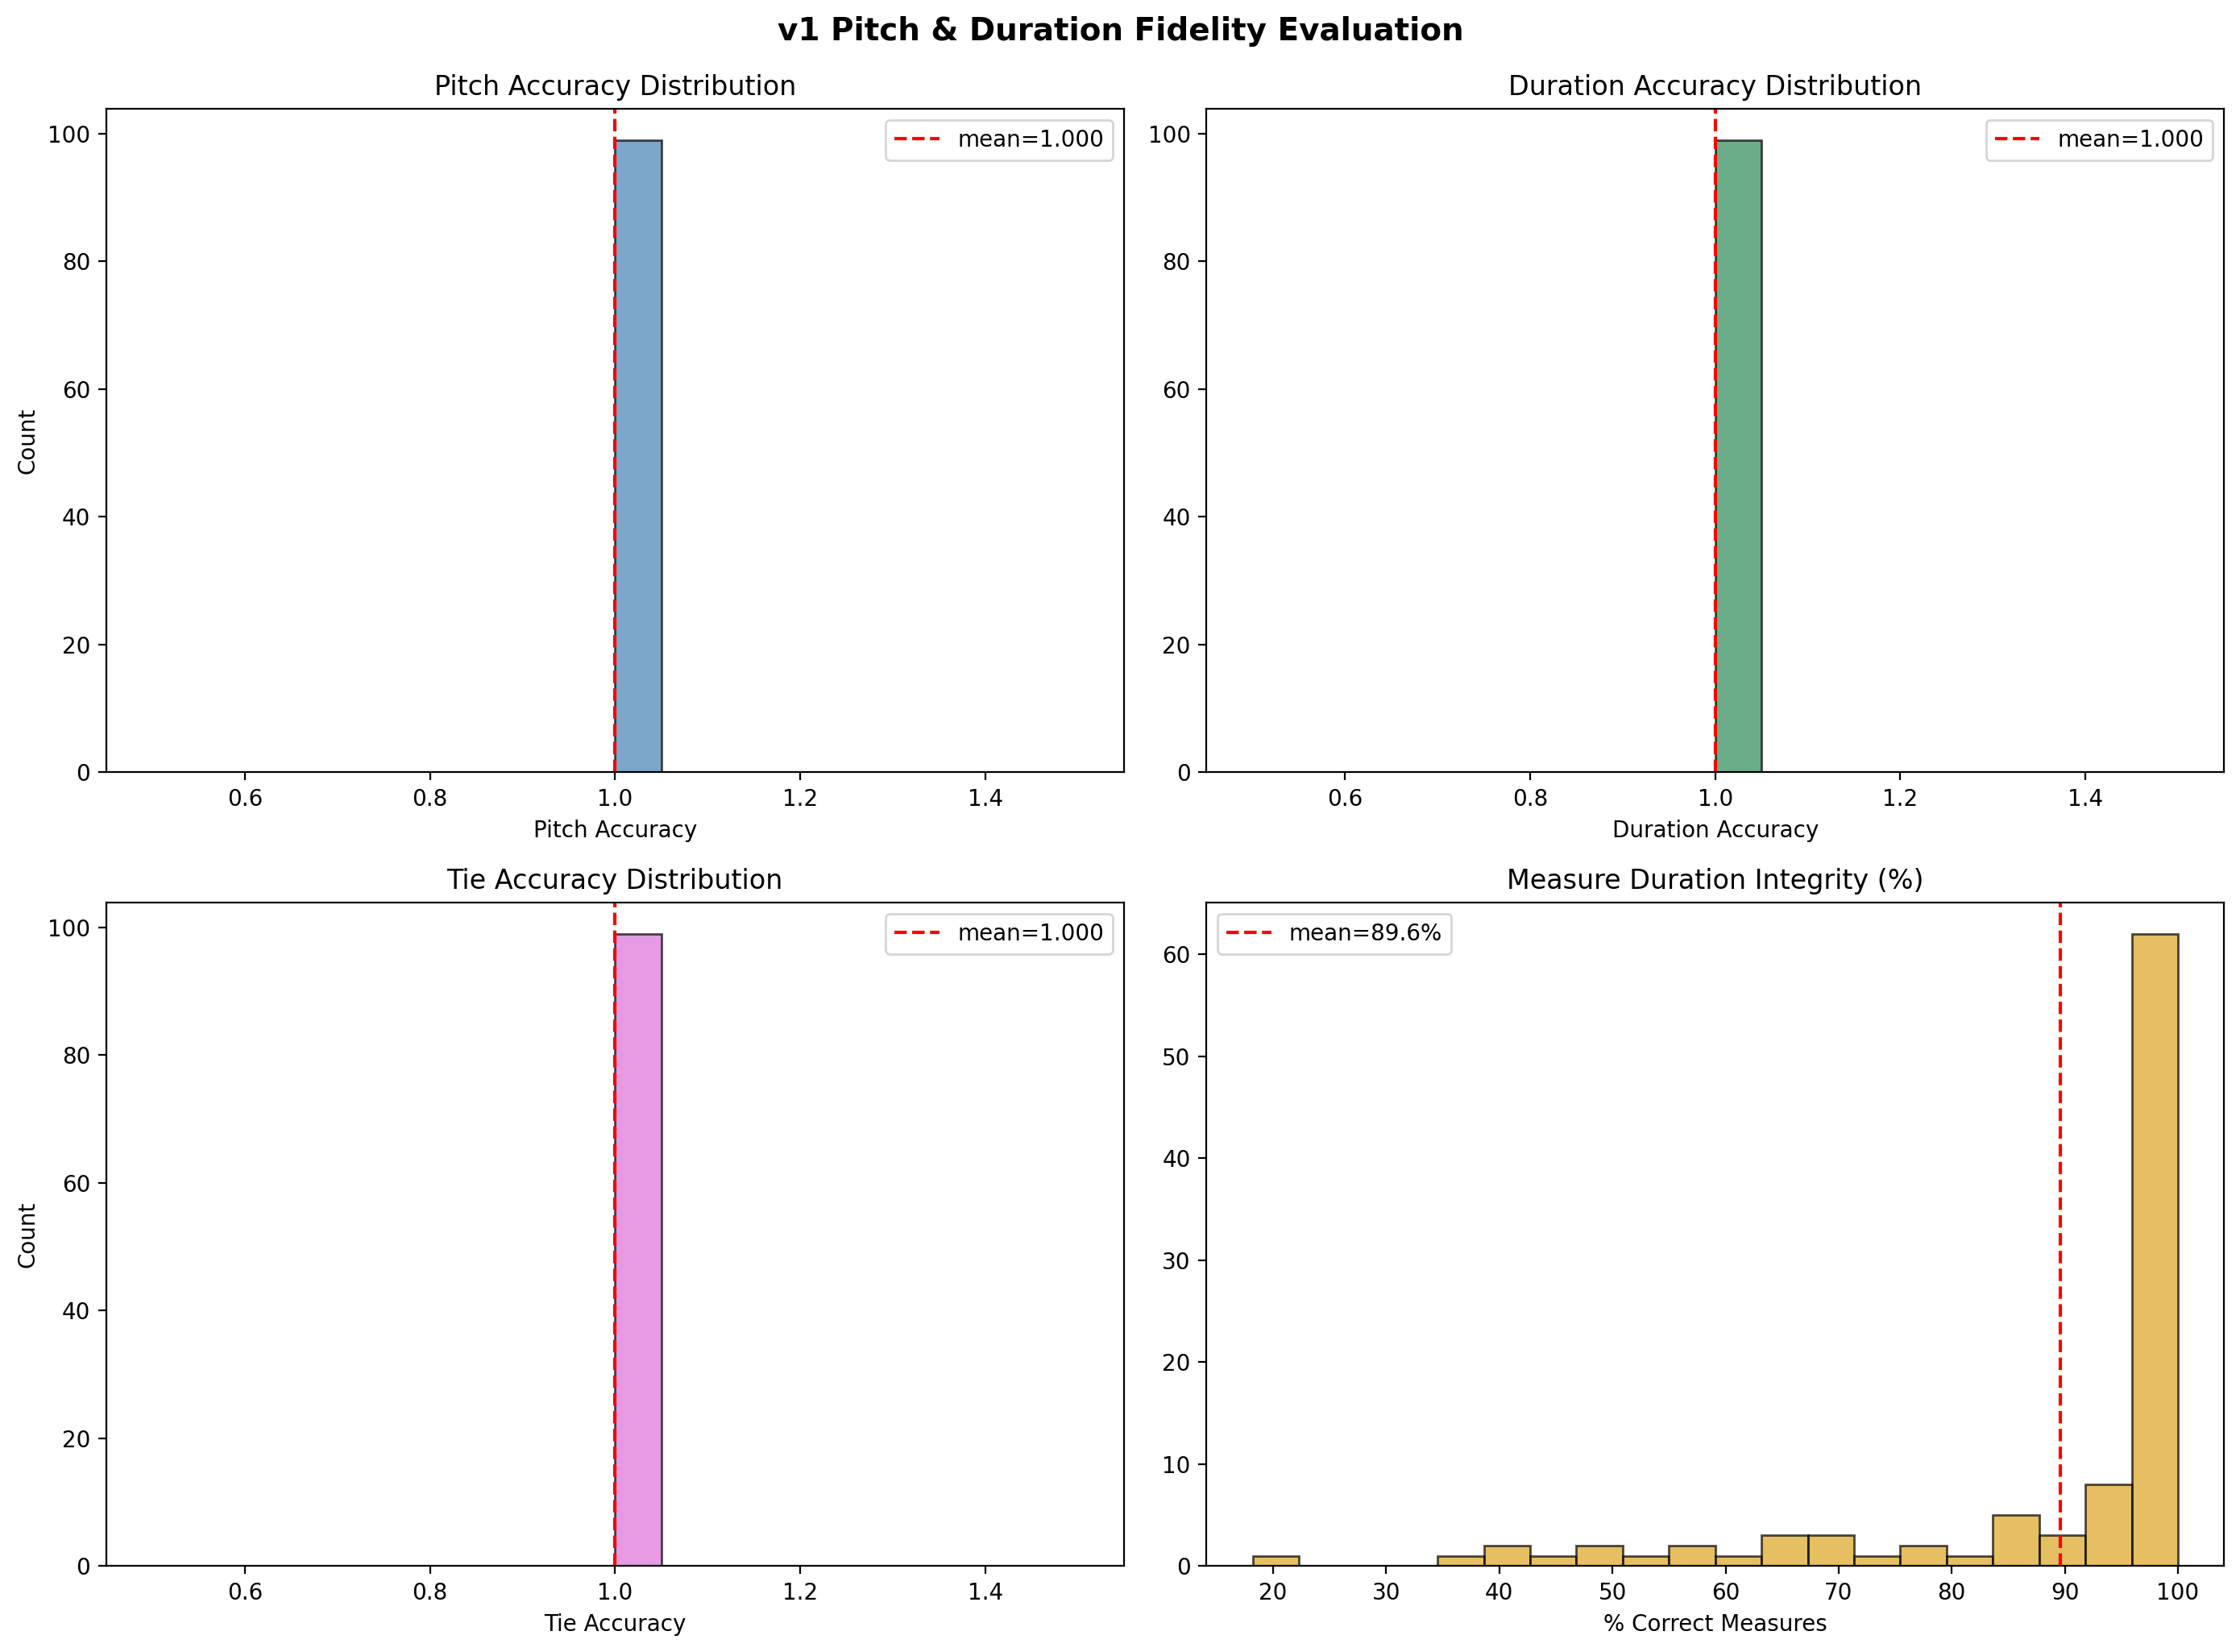

In [19]:
# ── Visualizations (v1) ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pitch accuracy histogram
axes[0, 0].hist(eval_ok['pitch_accuracy'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Pitch Accuracy Distribution')
axes[0, 0].set_xlabel('Pitch Accuracy')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(eval_ok['pitch_accuracy'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['pitch_accuracy'].mean():.3f}")
axes[0, 0].legend()

# Duration accuracy histogram
axes[0, 1].hist(eval_ok['duration_accuracy'], bins=20, edgecolor='black', alpha=0.7, color='seagreen')
axes[0, 1].set_title('Duration Accuracy Distribution')
axes[0, 1].set_xlabel('Duration Accuracy')
axes[0, 1].axvline(eval_ok['duration_accuracy'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['duration_accuracy'].mean():.3f}")
axes[0, 1].legend()

# Tie accuracy histogram
axes[1, 0].hist(eval_ok['tie_accuracy'], bins=20, edgecolor='black', alpha=0.7, color='orchid')
axes[1, 0].set_title('Tie Accuracy Distribution')
axes[1, 0].set_xlabel('Tie Accuracy')
axes[1, 0].set_ylabel('Count')
axes[1, 0].axvline(eval_ok['tie_accuracy'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['tie_accuracy'].mean():.3f}")
axes[1, 0].legend()

# Measure integrity histogram
axes[1, 1].hist(eval_ok['measure_integrity_pct'], bins=20, edgecolor='black', alpha=0.7, color='goldenrod')
axes[1, 1].set_title('Measure Duration Integrity (%)')
axes[1, 1].set_xlabel('% Correct Measures')
axes[1, 1].axvline(eval_ok['measure_integrity_pct'].mean(), color='red', linestyle='--',
                   label=f"mean={eval_ok['measure_integrity_pct'].mean():.1f}%")
axes[1, 1].legend()

plt.tight_layout()
plt.suptitle('v1 Pitch & Duration Fidelity Evaluation', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 9. Inspect Worst-Scoring Files and Error Analysis

In [20]:
# ── Error analysis (v1) ──
worst_files = eval_ok.nsmallest(5, 'combined_accuracy')

print("=" * 70)
print("TOP 5 WORST-SCORING FILES (by combined accuracy)")
print("=" * 70)

for _, row in worst_files.iterrows():
    fp = row['file']
    print(f"\n{'─' * 60}")
    print(f"File: {row['filename']}")
    print(f"  Pitch accuracy:    {row['pitch_accuracy']:.4f}")
    print(f"  Duration accuracy: {row['duration_accuracy']:.4f}")
    print(f"  Tie accuracy:      {row['tie_accuracy']:.4f}")
    print(f"  Combined accuracy: {row['combined_accuracy']:.4f}")
    print(f"  Measure integrity: {row['measure_integrity_pct']:.1f}%")
    print(f"  Notes: {row['n_original']} orig → {row['n_reconstructed']} recon")
    print(f"  Grace notes: {row['n_grace_original']} orig, {row['n_grace_reconstructed']} recon")
    print(f"  TIE tokens: {row['n_tie_tokens']}, GRACE tokens: {row['n_grace_tokens']}")
    print(f"  Length match: {row['length_match']}")

    # Show first 40 tokens
    try:
        tokens = tokenize(fp)
        print(f"\n  First 40 tokens:")
        for i, t in enumerate(tokens[:40]):
            print(f"    [{i:3d}] {t}")
    except Exception as e:
        print(f"  Error re-tokenizing: {e}")

# ── Error pattern analysis ──
print("\n\n" + "=" * 70)
print("ERROR PATTERN ANALYSIS (v1)")
print("=" * 70)

error_categories = Counter()
for _, row in eval_ok.iterrows():
    if not row['length_match']:
        error_categories['length_mismatch'] += 1
    if row['pitch_accuracy'] < 1.0:
        error_categories['pitch_errors'] += 1
    if row['duration_accuracy'] < 1.0:
        error_categories['duration_errors'] += 1
    if row['tie_accuracy'] < 1.0:
        error_categories['tie_errors'] += 1
    if row['measure_integrity_pct'] < 100.0:
        error_categories['measure_integrity_errors'] += 1

print(f"\n  Total files evaluated: {len(eval_ok)}")
for cat, count in error_categories.most_common():
    print(f"  {cat}: {count}/{len(eval_ok)} ({count/len(eval_ok)*100:.1f}%)")

# v1 feature coverage
print(f"\n\nv1 Feature Coverage:")
files_with_ties = len(eval_ok[eval_ok['n_tie_tokens'] > 0])
files_with_graces = len(eval_ok[eval_ok['n_grace_tokens'] > 0])
print(f"  Files with TIE tokens: {files_with_ties}/{len(eval_ok)} ({files_with_ties/len(eval_ok)*100:.1f}%)")
print(f"  Files with GRACE tokens: {files_with_graces}/{len(eval_ok)} ({files_with_graces/len(eval_ok)*100:.1f}%)")
print(f"  Total TIE tokens in sample: {eval_ok['n_tie_tokens'].sum()}")
print(f"  Total GRACE tokens in sample: {eval_ok['n_grace_tokens'].sum()}")

print("\n\nRemaining v1 limitations:")
print("  1. Microtone reconstruction is approximate (music21 microtone ≠ MusicXML alter)")
print("  2. TIE_START+TIE_STOP on same note → music21.tie.Tie('continue') may not round-trip")
print("  3. Grace note duration type defaults to eighth (original type info lost)")
print("  4. Pickup measures still cause measure integrity < 100%")
print("  5. Repeats, dynamics, articulations not yet tokenized (v2+)")

TOP 5 WORST-SCORING FILES (by combined accuracy)

────────────────────────────────────────────────────────────
File: sultaniyegah--sarki--duyek--kacinci_fasl-i--cevdet_cagla.xml
  Pitch accuracy:    1.0000
  Duration accuracy: 1.0000
  Tie accuracy:      1.0000
  Combined accuracy: 1.0000
  Measure integrity: 100.0%
  Notes: 277 orig → 277 recon
  Grace notes: 0 orig, 0 recon
  TIE tokens: 0, GRACE tokens: 0
  Length match: True

  First 40 tokens:
    [  0] <BOS>
    [  1] PART_S
    [  2] TIME_SIG_8/8
    [  3] KEY_B-flat_C-sharp
    [  4] CLEF_G_2
    [  5] BAR_1
    [  6] POS_BAR_0.0
    [  7] POS_ABS_0.0
    [  8] PITCH_A_+0.00_4
    [  9] DUR_0.5
    [ 10] POS_BAR_0.5
    [ 11] POS_ABS_0.5
    [ 12] PITCH_D_-1.89_5
    [ 13] DUR_1.0
    [ 14] POS_BAR_1.5
    [ 15] POS_ABS_1.5
    [ 16] PITCH_E_+1.89_5
    [ 17] DUR_0.5
    [ 18] POS_BAR_2.0
    [ 19] POS_ABS_2.0
    [ 20] PITCH_F_-7.55_5
    [ 21] DUR_0.5
    [ 22] POS_BAR_2.5
    [ 23] POS_ABS_2.5
    [ 24] PITCH_G_-3.77_5
    [